# Mosaics

In [1]:
from datetime import datetime
    
import matplotlib.pyplot as plt
import matplotlib.colors
import aacgmv2
import numpy as np
import scipy.interpolate
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree
try:
    import cartopy.crs as ccrs
    transform=ccrs.PlateCarree()
except ImportError:
    transform=None

import asilib
import asilib.asi
import asilib.map
import asilib.utils

print(f'asilib version: {asilib.__version__}')

asilib version: 0.25.3


We first create an `asilib.Imagers()` object consisting of TREx-RGB `asilib.Imagers()` defined a list of location_codes.

In [2]:
asilib.asi.trex.trex_rgb_info()

,array,location_code,name,latitude,longitude
0,TREx_RGB,ATHA,Athabasca,54.60,-113.64
1,TREx_RGB,FSMI,Fort Smith,60.03,-111.93
2,TREx_RGB,GILL,Gillam,56.38,-94.64
3,TREx_RGB,LUCK,Lucky Lake,51.15,-107.26
4,TREx_RGB,PINA,Pinawa,50.26,-95.87
5,TREx_RGB,RABB,Rabbit Lake,58.23,-103.68


In [3]:
time = datetime(2021, 11, 4, 7, 3, 51)
location_codes = ['FSMI', 'LUCK', 'RABB', 'PINA', 'GILL']
map_alt = 110
min_elevation = 10

In [4]:
_imagers = []

for location_code in location_codes:
    _imagers.append(asilib.asi.trex.trex_rgb(location_code, time=time, alt=map_alt))

asis = asilib.Imagers(_imagers)

Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


Plot a TREx-RGB mosaic with and without AACGM magnetic latitude contours.

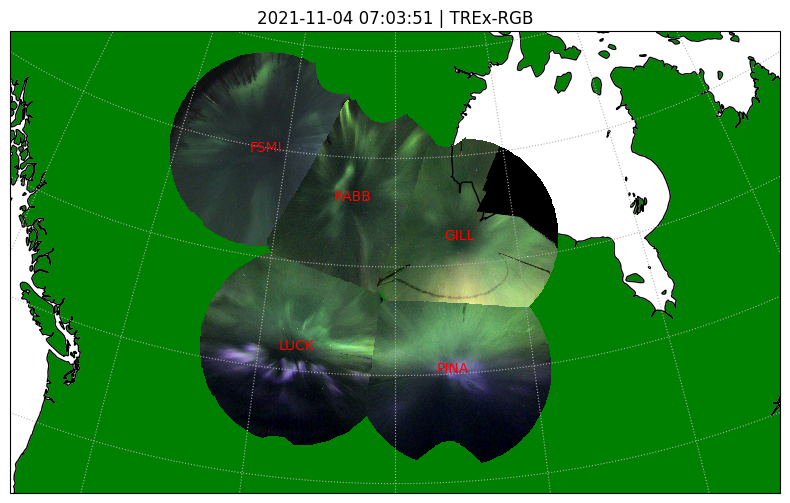

In [5]:
lon_bounds=(-125, -75)
lat_bounds=(43, 64)
ax = asilib.map.create_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
asis.plot_map(ax=ax, overlap=False, min_elevation=min_elevation)
plt.title(f'{time} | TREx-RGB');

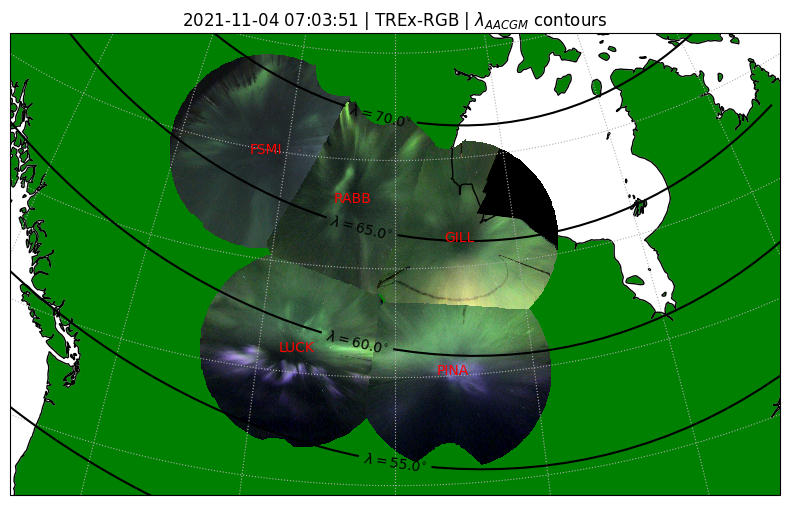

In [6]:
lat_grid, lon_grid = np.meshgrid(
    np.linspace(lat_bounds[0]-5, lat_bounds[1]+5), 
    np.linspace(lon_bounds[0]-10, lon_bounds[1]+10, num=51)
    )
# Need to pass flattened arrays since aacgmv2 does not work with n-D arrays.
aacgm_lat_grid, aacgm_lon_grid, _ = aacgmv2.wrapper.convert_latlon_arr(
    lat_grid.flatten(), lon_grid.flatten(), 110, time, method_code='G2A'
    )
aacgm_lat_grid = aacgm_lat_grid.reshape(lat_grid.shape)
aacgm_lon_grid = aacgm_lon_grid.reshape(lon_grid.shape)

ax = asilib.map.create_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
asis.plot_map(ax=ax, overlap=False, min_elevation=min_elevation)
cs = plt.contour(lon_grid, lat_grid, aacgm_lat_grid, colors='k', transform=transform)
ax.clabel(cs, inline=True, fontsize=10, fmt=lambda x: f'$\lambda = {{{x}}}^{{\circ}}$')
plt.title(f'{time} | TREx-RGB | $\lambda_{{AACGM}}$ contours');

Now lets try to put the mosaic onto a custom grid.

In [7]:
lat_lon_points, intensities = asis.get_points(min_elevation=min_elevation)
lat_grid2, lon_grid2 = np.meshgrid(np.linspace(*lat_bounds, num=1000), np.linspace(*lon_bounds, num=1001))
rgb_grid = scipy.interpolate.griddata(lat_lon_points, intensities, (lat_grid2, lon_grid2), method='cubic')
g_grid = scipy.interpolate.griddata(lat_lon_points, intensities[:, 1], (lat_grid2, lon_grid2), method='cubic')
b_grid = scipy.interpolate.griddata(lat_lon_points, intensities[:, 2], (lat_grid2, lon_grid2), method='cubic')

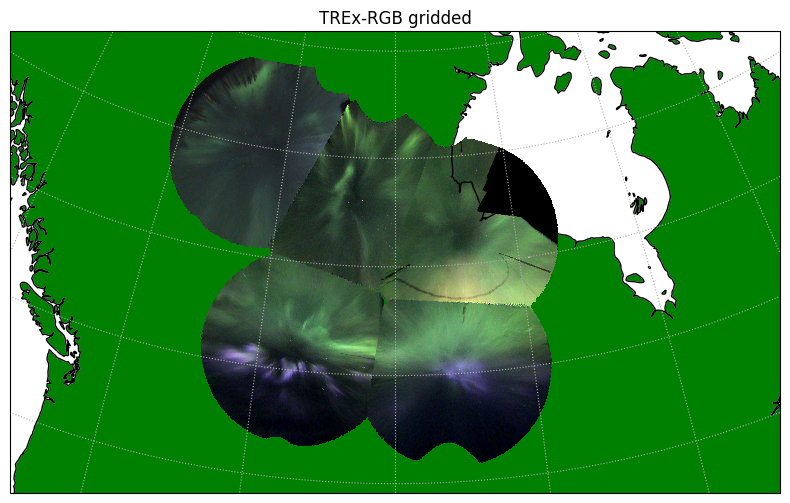

In [8]:
rgb_grid_copy = rgb_grid.copy()
# We need to mask out the gridded points that are far away from the original points as NaNs and this 
# is the most efficient way (source: https://stackoverflow.com/a/31189177)
tree = cKDTree(lat_lon_points)
xi = _ndim_coords_from_arrays((lat_grid2, lon_grid2), ndim=2)
dists, indexes = tree.query(xi)
rgb_grid_copy[dists > 0.1, :] = np.nan

# Need to scale the RGB values to [0, 1] for matplotlib to make the colors more vibrant.
vmin, vmax = asis.imagers[0].get_color_bounds()
rgb_grid_copy = asis.imagers[0]._rgb_replacer(rgb_grid_copy)
rgb_grid_copy = asilib.utils.stretch_contrast(rgb_grid_copy, vmin, vmax)

# Add a transparency channel so that the NaN RGB values show up as transparent instead of black.
rgb_grid_copy = np.concatenate(
    (rgb_grid_copy, np.ones(rgb_grid_copy.shape[:2]).reshape(*rgb_grid_copy.shape[:2], 1))
    , axis=-1
    )
rgb_grid_copy[np.isnan(rgb_grid_copy.sum(axis=-1)), -1] = 0

ax = asilib.map.create_map(lon_bounds=lon_bounds, lat_bounds=lat_bounds)
ax.pcolormesh(lon_grid2, lat_grid2, rgb_grid_copy, transform=transform)
ax.set_title('TREx-RGB gridded');

Looks good enough for a 100x101 grid! Now, how about the individual colors and green-blue ratio?

First, the blue grid:

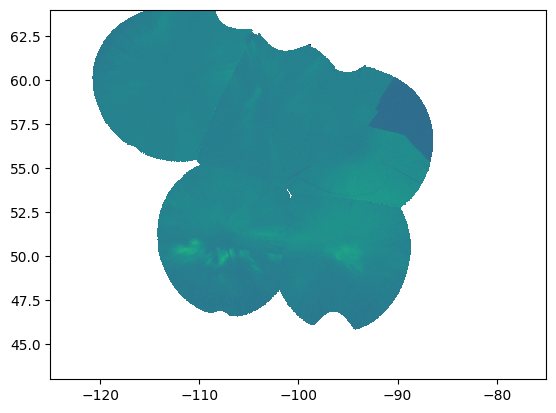

In [9]:
b_grid[dists > 0.1] = np.nan
plt.pcolormesh(lon_grid2, lat_grid2, b_grid)

And the green grid:

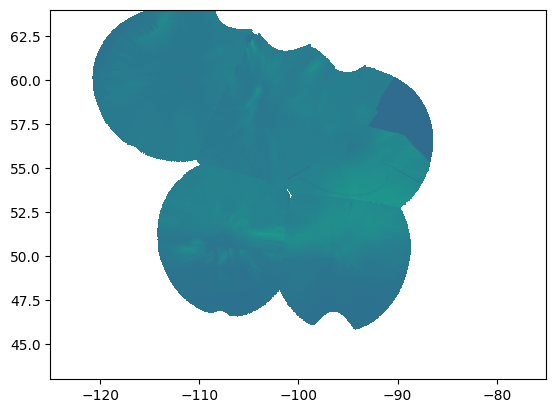

In [10]:
g_grid[dists > 0.1] = np.nan
plt.pcolormesh(lon_grid2, lat_grid2, g_grid)

And the ratio:

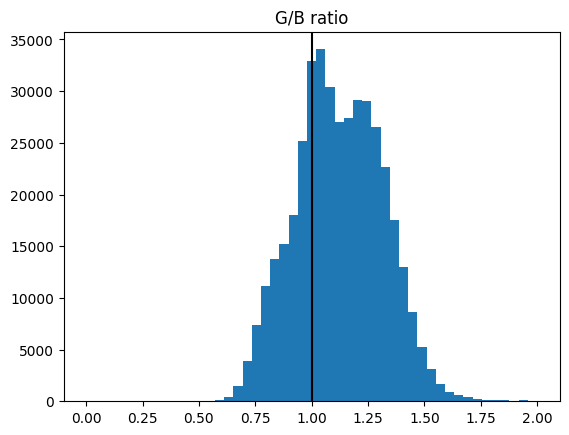

In [11]:
plt.hist((g_grid/b_grid).flatten(), bins=np.linspace(0, 2));
plt.title('G/B ratio')
plt.axvline(1, c='k')

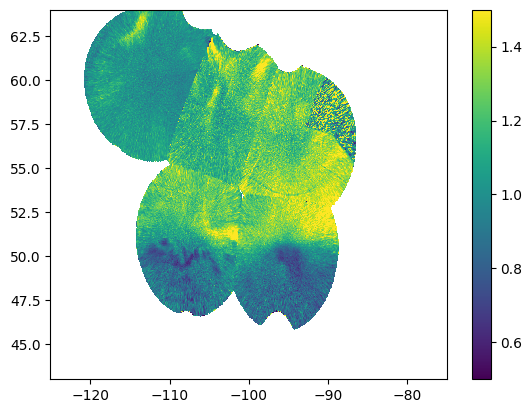

In [12]:
plt.pcolormesh(lon_grid2, lat_grid2, g_grid/b_grid, vmin=0.5, vmax=1.5)
plt.colorbar()

Normalized ratio

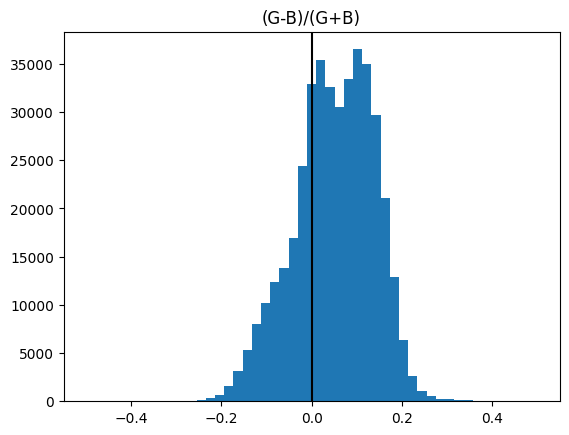

In [13]:
plt.hist(((g_grid-b_grid)/(g_grid+b_grid)).flatten(), bins=np.linspace(-0.5, 0.5));
plt.title('(G-B)/(G+B)')
plt.axvline(0, c='k')

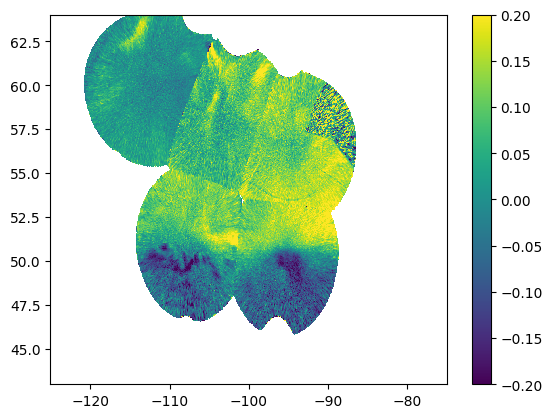

In [14]:
plt.pcolormesh(lon_grid2, lat_grid2, (g_grid-b_grid)/(g_grid+b_grid), vmin=-0.2, vmax=0.2)
plt.colorbar()